In [18]:
import numpy as np
from scipy.ndimage.filters import generic_filter as gf
import scipy.stats.mstats as ms
from scipy.stats import skew
import matplotlib.pyplot as plt
import re
import os
import pandas as pd

In [19]:
import glob
raw_feature_files = glob.glob("*.npy")[3:]
raw_feature_names = list(map(lambda s: s.split(".")[0], raw_feature_files))

In [42]:
def extract_numpy_files_in_folder(path, skip=[]):
    """
    Returns all the .npy files in a given directory.
    Skips subdirectorys
    """
    root, _, files = next(os.walk(path))
    holder = []
    for file in files:
        if file[-3:] != ".npy":
            continue
        elif file in skip:
            continue
        holder.append(os.path.join(root,file))
    return holder

The features that will be extracted will be using these settings.

In [20]:
def generate_mask(small_radius, big_radius):
    """
    Generate a mask in a circular radius around a point.
    Possibly to create ring masks with this
    """
    height, width = big_radius*2,big_radius*2
    Y, X = np.ogrid[:height+1, :width+1]
    distance_from_center = np.sqrt((X- big_radius)**2 + (Y-big_radius)**2)
    mask = (small_radius <= distance_from_center) & (distance_from_center <= big_radius)
    return mask

def circel_mask_generator(radius):
    """
    Wrapper around generate_mask for usage when only a circular radius
    is required.
    """
    return generate_mask(1,radius)


radius_1 = 2
radius_2 = 4
radius_3 = 6

mask1_1meter_wide = generate_mask(1, radius_1)
mask2_2meter_wide = generate_mask(1, radius_2)
mask3_3meter_wide = generate_mask(1, radius_3)

In [21]:
def create_filter_with_mask(postfix, arr_with_filenames, function, mask):
    """
    Create a filter over an array of filenames.npy files,
    Existing files with correct naming schemas will NOT be updated if existing.
    _raw files will be skipped.
    Returns a iterator that can be used to show/save filterd array. A name is also yielded.
    """
    for filename in arr_with_filenames:
        if filename[-4:] != "_raw":
            continue
        elif os.path.isfile(f"./{filename[:-4]}_{postfix}.npy"):
            continue
        arr = np.load(f"{filename}.npy")
        holder = gf(arr, function, footprint=mask)
        yield (f"{filename[:-4]}_{postfix}", holder)

In [23]:
for name, data in create_filter_with_mask("std_6x6", raw_feature_names, np.nanstd, mask3_3meter_wide):
    np.save(f"{name}.npy", data)

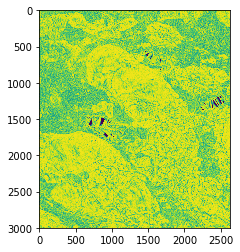

In [24]:
plt.imshow(np.load("Impoundment_zone1_std_6x6.npy"))

In [51]:
def merge_numpy_zones_files(list_of_files):
    """
    Takes a list of paths to files and load them into a panda DataFrame.
    if the name contains the word ditches the name is replaced by 'labels'
    Only one zone should be contained inside the list.
    """
    holder = {}
    for file in list_of_files:
        if "ditches" in file or "Ditches" in file:
            holder["labels"] = np.load(file).reshape(-1)
        else:
            holder [file.split("/")[-1][:-4]] = np.load(file).reshape(-1)
    return pd.DataFrame(data=holder)

In [52]:
merge_numpy_zones_files(["./Ditches_zone1_raw.npy","./HPMF_zone2_raw.npy"]).head()


,labels,HPMF_zone2_raw
0,0,1022739087
1,0,1035489772
2,0,1039516303
3,0,1039516303
4,0,1032805417
